### О задании

В этом задании вы:
- ознакомитесь с тем, что происходит "внутри" метода опорных векторов и логистической регрессии
- познакомитесь с калибровкой вероятности
- изучите методы трансформации переменных и методы отбора признаков
- попробуете оценить экономический эффект модели


### Оценивание и штрафы
Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 10 баллов.

Сдавать задание после указанного срока сдачи нельзя. При выставлении неполного балла за задание в связи с наличием ошибок на усмотрение проверяющего предусмотрена возможность исправить работу на указанных в ответном письме условиях.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.


### Формат сдачи
Для сдачи задания переименуйте получившийся файл *.ipynb в соответствии со следующим форматом: homework-practice-04-classification-Username.ipynb, где Username — ваша фамилия и имя на латинице именно в таком порядке (например, homework-practice-04-classification-IvanovIvan.ipynb).

Для удобства проверки самостоятельно посчитайте свою максимальную оценку (исходя из набора решенных задач) и укажите ниже.

**Оценка**: 

In [1428]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import average_precision_score, make_scorer, roc_curve, auc, precision_recall_curve
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC, SVC
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from scipy.special import expit

sns.set_style('whitegrid')
plt.rcParams.update({'font.size': 14})
%matplotlib inline

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

# Часть 0. SVM, LR и калибровка вероятностей. 

Сгенерируем синтетические данные.

In [1429]:
from sklearn.datasets import make_classification
X, y = make_classification(
    n_samples=10000, n_features=10, n_informative=5, n_redundant=5,
    random_state=42)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42)

__Задание 1.__ Обучение и применение метода опорных векторов и логистической регрессии.

__(1 балл)__

Обучите метод опорных векторов. На занятиях мы проходили линейный вариант без ядрового перехода, что соответствует линейному ядру (`LinearSVC` или же `SVC(kernel='linear')` в `sklearn.svm`). Подберите параметр регуляризации `C` (можете воспользоваться кросс-валидацией или отделить валидационную выборку от обучающей). __Здесь и далее, если не сказано иначе, подбирайте оптимальные гиперпараметры с точки зрения AUC-PR.__

In [1431]:
from sklearn.model_selection import PredefinedSplit, GridSearchCV
import random

test_fold = [-1] * round(len(X_train) * 0.8) + [0] *  round(len(X_train) * 0.2)
random.shuffle(test_fold)
ps = PredefinedSplit(test_fold)

In [1432]:
C_value = np.logspace(-4, 0, num=40)
searcher_C = GridSearchCV(LinearSVC(), [{"C": C_value}], cv=ps, refit=True,
                          scoring=make_scorer(average_precision_score))
searcher_C.fit(X_train, y_train)
best_C = searcher_C.best_params_["C"]
print("Best C value = %.4f" % best_C)
svc_pred = searcher_C.decision_function(X_test)
print('SVC PR-AUC:', average_precision_score(y_test, svc_pred))

Best C value = 0.0055
SVC PR-AUC: 0.8298399130838225


На тестовой части постройте ROC и PR кривые, а также посчитайте AUC-ROC, AUC-PR с точностью до 5 знаков. Сравните AUC-ROC и AUC-PR для вашей модели с этими же метриками для случайного классификатора (который на каждом объекте выдаёт один из двух классов с равными вероятностями).

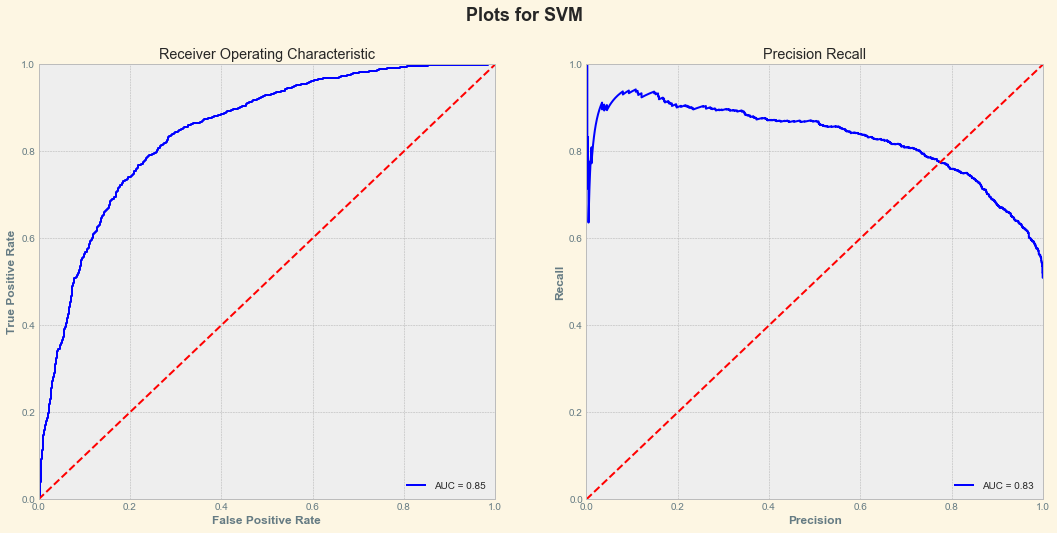

In [1444]:
#https://stackoverflow.com/questions/29656550/how-to-plot-pr-curve-over-10-folds-of-cross-validation-in-scikit-learn
#https://stackoverflow.com/questions/25009284/how-to-plot-roc-curve-in-python

plt.style.use('bmh')
svc_pred = searcher_C.decision_function(X_test)
fpr, tpr, threshold = roc_curve(y_test, svc_pred)
roc_auc = auc(fpr, tpr)

precision, recall, threshold = precision_recall_curve(y_test, svc_pred)
pr_auc = auc(recall, precision)

fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize=(18, 8))
fig.suptitle('Plots for SVM', fontweight='bold', fontsize=18)

ax[0].set_title('Receiver Operating Characteristic')
ax[0].plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
ax[0].legend(loc = 'lower right')
ax[0].plot([0, 1], [0, 1],'r--')
ax[0].set_xlim([0, 1])
ax[0].set_ylim([0, 1])
ax[0].set_ylabel('True Positive Rate', fontweight='bold')
ax[0].set_xlabel('False Positive Rate', fontweight='bold')


ax[1].set_title('Precision Recall')
ax[1].plot(recall, precision, 'b', label = 'AUC = %0.2f' % pr_auc)
ax[1].legend(loc = 'lower right')
ax[1].plot([0, 1], [0, 1],'r--')
ax[1].set_xlim([0, 1])
ax[1].set_ylim([0, 1])
ax[1].set_ylabel('Recall', fontweight='bold')
ax[1].set_xlabel('Precision', fontweight='bold')
plt.show()

In [1440]:
from mlxtend.evaluate import lift_score

dm_pred = [0.5] * y_test.shape[0]

print('SVC PR-AUC:', round(average_precision_score(y_test, svc_pred), 5))
print('SVC ROC-AUC:', round(roc_auc_score(y_test, svc_pred), 5))
print('Dummy SVC PR-AUC:', round(average_precision_score(y_test, dm_pred), 5))
print('SVC ROC-AUC:', round(roc_auc_score(y_test, dm_pred), 5))
print('Lift score:', round(lift_score(y_test, searcher_C.predict(X_test)), 5))

SVC PR-AUC: 0.82984
SVC ROC-AUC: 0.84761
Dummy SVC PR-AUC: 0.50567
SVC ROC-AUC: 0.5
Lift score: 1.53667


А теперь проделайте все то же самое для логистической регрессии (LR) — обучение, подбор параметра регуляризации (используйте L2-регуляризацию), вычисление всех метрик и построение кривых. Сравните результаты LR и SVM с точки зрения всех вычисленных критериев качества, объясните различия (если они есть).

In [1467]:
searcher_L2 = GridSearchCV(LogisticRegression(), [{"C": C_value}], cv=ps, refit=True,
                          scoring=make_scorer(average_precision_score))
searcher_L2.fit(X_train, y_train)
best_L2 = searcher_L2.best_params_["C"]
print("Best L2 value = %.4f" % best_L2)
lr_pred = searcher_L2.decision_function(X_test)
print('Logistic Regression PR-AUC:', average_precision_score(y_test, lr_pred))

Best L2 value = 0.0003
Logistic Regression PR-AUC: 0.8340631130040753


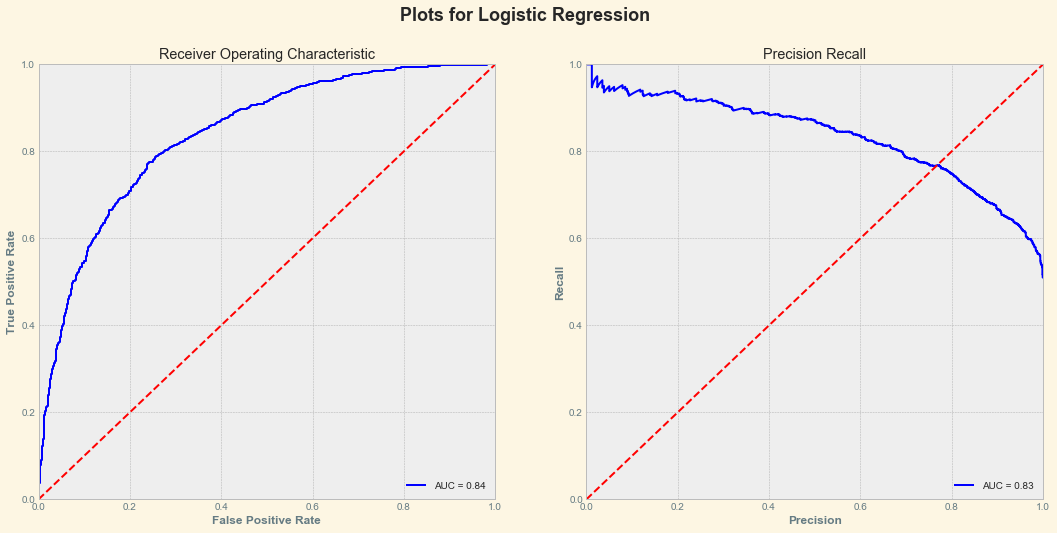

In [1445]:
lr_pred = searcher_L2.decision_function(X_test)
fpr, tpr, threshold = roc_curve(y_test, lr_pred)
roc_auc = auc(fpr, tpr)

precision, recall, threshold = precision_recall_curve(y_test, lr_pred)
pr_auc = auc(recall, precision)

fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize=(18, 8))
fig.suptitle('Plots for Logistic Regression', fontweight='bold', fontsize=18)

ax[0].set_title('Receiver Operating Characteristic')
ax[0].plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
ax[0].legend(loc = 'lower right')
ax[0].plot([0, 1], [0, 1],'r--')
ax[0].set_xlim([0, 1])
ax[0].set_ylim([0, 1])
ax[0].set_ylabel('True Positive Rate', fontweight='bold')
ax[0].set_xlabel('False Positive Rate', fontweight='bold')


ax[1].set_title('Precision Recall')
ax[1].plot(recall, precision, 'b', label = 'AUC = %0.2f' % pr_auc)
ax[1].legend(loc = 'lower right')
ax[1].plot([0, 1], [0, 1],'r--')
ax[1].set_xlim([0, 1])
ax[1].set_ylim([0, 1])
ax[1].set_ylabel('Recall', fontweight='bold')
ax[1].set_xlabel('Precision', fontweight='bold')
plt.show()

In [1446]:
from mlxtend.evaluate import lift_score
print('LogReg PR-AUC:', round(average_precision_score(y_test, lr_pred), 5))
print('LogReg ROC-AUC:', round(roc_auc_score(y_test, lr_pred), 5))
print('Dummy LogReg PR-AUC:', round(average_precision_score(y_test, dm_pred), 5))
print('Dummy LogReg ROC-AUC:', round(roc_auc_score(y_test, dm_pred), 5))
print('Lift score:', round(lift_score(y_test, searcher_L2.predict(X_test)), 5))

SVC PR-AUC: 0.83406
SVC ROC-AUC: 0.84032
Dummy SVC PR-AUC: 0.50567
Dummy SVC ROC-AUC: 0.5
Lift score: 1.51846


Различия практтически нет. SVC показала лучший lift score, тогда как две используемые метрики площадей под кривой дают схожие результаты с разницей в сотую.

В названии метода опорных векторов присутствуют некоторые "опорные векторы". Сгенерируйте синтетические данные с помощью `make_classification` с 2 признаками, обучите на нём метод опорных векторов. Визуализируйте разделяющую прямую, все объекты и выделите опорные векторы (атрибут `support_vectors_`). В этот раз, если необходимо, вместо `LinearSVC` воспользуйтесь `SVC(kernel='linear')`, так как только в нём есть информация об опорных векторах.

In [1460]:
# https://scikit-hep.org/root_numpy/auto_examples/tmva/plot_twoclass.html
# https://scikit-learn.org/stable/auto_examples/svm/plot_separating_hyperplane.html
# https://stackoverflow.com/questions/28256058/plotting-decision-boundary-of-logistic-regression

X, y = make_classification(
     n_samples=1000, n_features=2, n_informative=2, n_redundant=0,
    random_state=42)

svc_special = SVC(kernel='linear', C = best_C).fit(X, y)


x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                     np.arange(y_min, y_max, 0.02))

xy = np.vstack([xx.ravel(), yy.ravel()]).T
Z = svc_special.decision_function(xy).reshape(xx.shape)

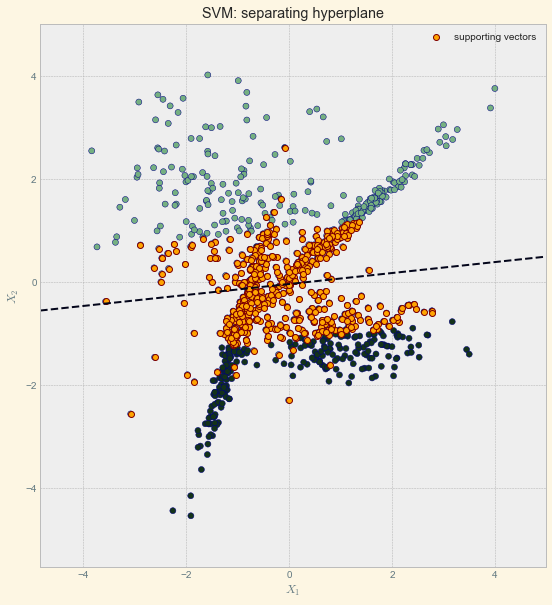

In [1454]:
plt.style.use('bmh')
fig, ax = plt.subplots(figsize=(10, 10))


ax.contour(xx, yy, Z, levels=[-1, 0, 1], linestyles='dashed')
ax.scatter(X[:, 0], X[:, 1], cmap=sns.cubehelix_palette(start=2, rot=0, dark=.15, light=.6, reverse=True, as_cmap=True), 
           c=y, edgecolors='navy')
ax.scatter(
    svc_special.support_vectors_[:, 0],
    svc_special.support_vectors_[:, 1],
    linewidth=1, color='orange', edgecolor='maroon', label='supporting vectors'
)
ax.set(aspect="equal", xlabel="$X_1$", ylabel="$X_2$", title="SVM: separating hyperplane")
ax.legend()
plt.show()

В отличие от метода опорных векторов, логистическая регрессия не пытается построить разделяющую гиперплоскость с максимальным отступом, а приближает в каждой точке пространства объектов вероятность положительных ответов $p(y=+1|x)$. Попробуйте нарисовать это распределение на плоскости, не забудьте отметить на ней все объекты. Вам может помочь функция `plt.pcolor`.

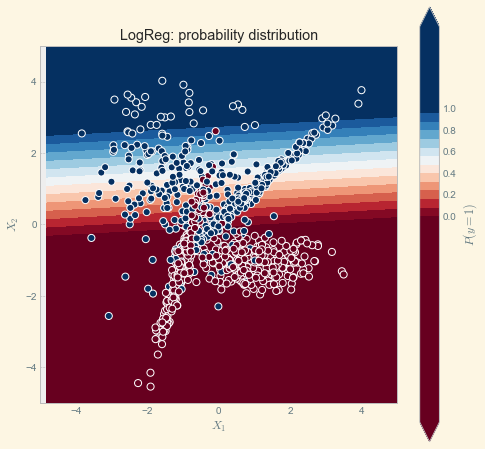

In [1473]:
plt.style.use('bmh')
lr_special = LogisticRegression(max_iter=100000, C = 0.001).fit(X, y)
Z = lr_special.decision_function(xy).reshape(xx.shape)

f, ax = plt.subplots(figsize=(8, 8))

contour = ax.contourf(xx, yy, Z, 50, cmap="RdBu",
                      vmin=0, vmax=1, extend='both')

ax_c = f.colorbar(contour)
ax_c.set_label("$P(y = 1)$")
ax_c.set_ticks([0, .2, .4, .6, 0.8, 1])

ax.scatter(X[:,0], X[:, 1], c=y, s=50,
           cmap="RdBu",
           edgecolor="white", linewidth=1)

ax.set(aspect="equal", xlim=(-5, 5), ylim=(-5, 5),
       xlabel="$X_1$", ylabel="$X_2$", title='LogReg: probability distribution')
plt.show()

__Задание 2.__ Калибровка вероятностей.

__(1 балл)__

Перейдём к оценке качества выдаваемых алгоритмами вероятностей. Начнём с калибровочных кривых. 

Допустим, алгоритм возвращает некоторые числа от нуля до единицы. Хорошо ли они оценивают вероятность? Для этого разобьем отрезок $[0, 1]$ на несколько маленьких отрезков одинаковой длины. Рассмотрим $i$-й отрезок с границами $[a_i, b_i]$ и предсказания $p_1, p_2, \dots, p_k$, которые попали в него. Пусть им соответствуют истинные ответы $y_1, y_2, \dots, y_k$. Если алгоритм выдает корректные вероятности, то среди этих истинных ответов должно быть примерно $(a_i + b_i) / 2$ единиц. Иными словами, если нарисовать кривую, у которой по оси X отложены центры отрезков, а по оси Y — доли единичных ответов этих в отрезках, то она должна оказаться диагональной. Ниже приведена функция, которая должна рисовать такие кривые. В ней допущено две ошибки — найдите и исправьте их.

In [590]:
def plot_calibration_curve(y_test, preds, method, ax):
    bin_middle_points = []
    bin_real_ratios = []
    n_bins = 10
    for i in range(n_bins):
        l = 1.0 / n_bins * i
        r = 1.0 / n_bins * (i + 1)
        bin_middle_points.append(l + (r - l) / 2) 
        bin_real_ratios.append(np.sum(y_test[(preds >= l) & (preds < r)]) / 
                               y_test[(preds >= l) & (preds < r)].shape[0])
    flag = int(method == 'SVC')
    ax[flag].plot(bin_middle_points, bin_real_ratios, label=method)
    ax[flag].set_ylim([-0.05, 1.05])
    ax[flag].set_title('Calibration for {}'.format(method))
    ax[flag].plot([0, 1], [0, 1],'r--', label='Perfect')
    ax[flag].grid(True)
    ax[flag].legend()

Сгенерируйте синтетические данные аналогично использованным в самом первом задании. Постройте калибровочные кривые на тестовой части для логистической регрессии и метода опорных векторов (не забудьте перевести его предсказания в $[0;1]$). Изучите распределение ответов классификаторов (постройте гистограммы с помощью `plt.hist`). Чем они различаются? Чем вы можете объяснить это?

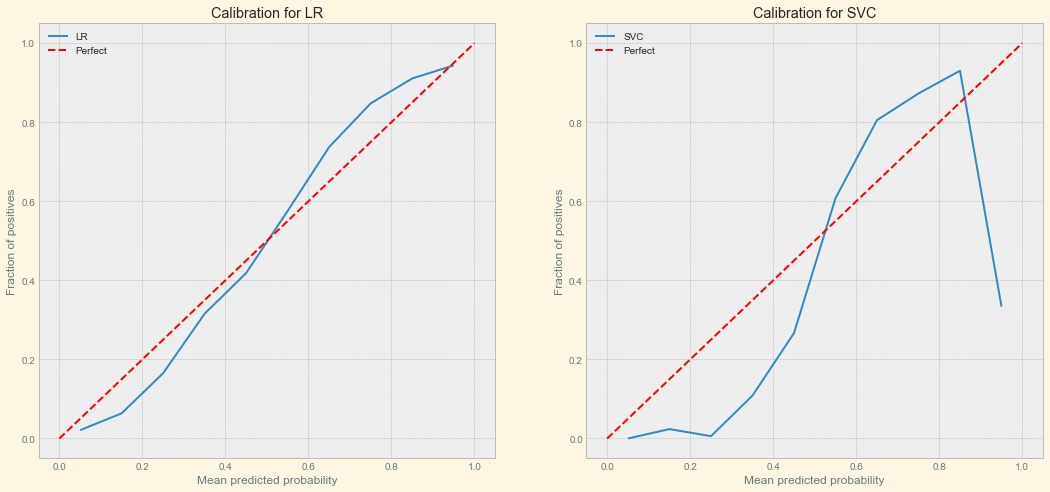

In [1482]:
X, y = make_classification(
    n_samples=10000, n_features=10, n_informative=5, n_redundant=5,
    random_state=42)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42)

fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (18, 8))
lr_calib = LogisticRegression(max_iter=100000, C = best_L2).fit(X_train, y_train)
preds_lr = lr_calib.predict_proba(X_test)[:, 1]
plot_calibration_curve(y_test, preds_lr, 'LR', ax)

svc_special = SVC(kernel='linear', C = best_C).fit(X_train, y_train)
preds_svc = svc_special.decision_function(X_test)
preds_svc1 = (preds_svc - preds_svc.min()) / (preds_svc.max() - preds_svc.min())
plot_calibration_curve(y_test, preds_svc1, 'SVC', ax)
ax[0].set(xlabel='Mean predicted probability', ylabel='Fraction of positives')
ax[1].set(xlabel='Mean predicted probability', ylabel='Fraction of positives')
plt.show()

Видим, что LR оказывается ближе к Perfect кривой, при чем контраст с результатами SVC колоссальный. Очевидно, что наблюдаемое нами есть следствие более высокой эффективности LR в предсказании вероятности.
При этом если говорить о распределениях, то SVC - нормальное распредение, а LR в форме симметричной ямы, схожей с равномерным распределением. Скорее всего, дела опять же в том что "логистическая регрессия не пытается построить разделяющую гиперплоскость с максимальным отступом, а приближает в каждой точке пространства объектов вероятность положительных ответов".

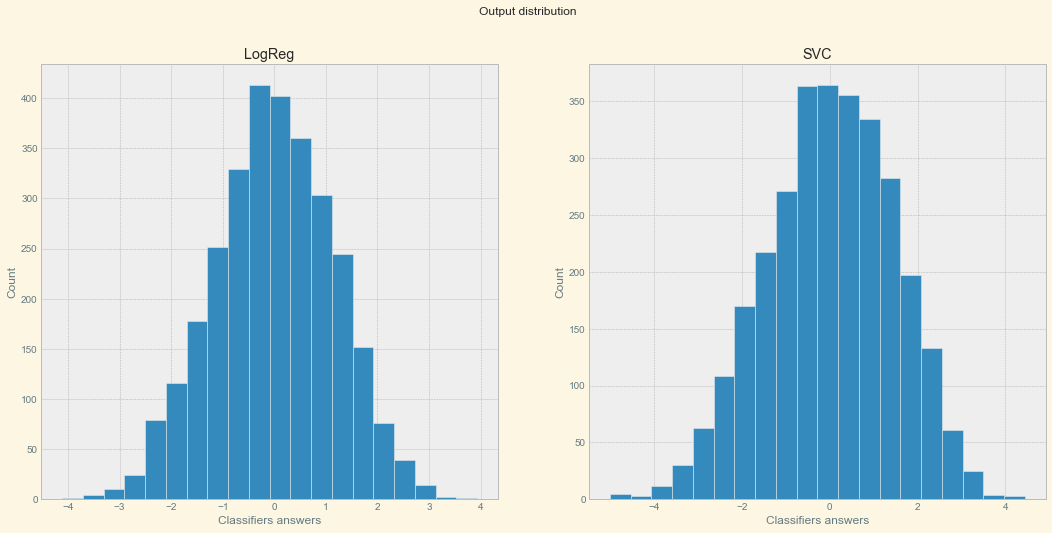

In [1479]:
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (18, 8))
ax[0].hist(preds_lr.decision_function(X_test), bins=20)
ax[1].hist(preds_svc, bins=20)
ax[0].set(title='LogReg', xlabel='Classifiers answers', ylabel='Count')
ax[1].set(title='SVC', xlabel='Classifiers answers', ylabel='Count')
fig.suptitle('Output distribution')
plt.show()

Воспользуйтесь `CalibratedClassifierCV` из `sklearn` для калибровки вероятностей метода опорных векторов на обучении и постройте с его помощью предсказания для тестовой выборки. Нарисуйте для них калибровочную кривую. Улучшилась ли она?

Улучшилась очевидно.

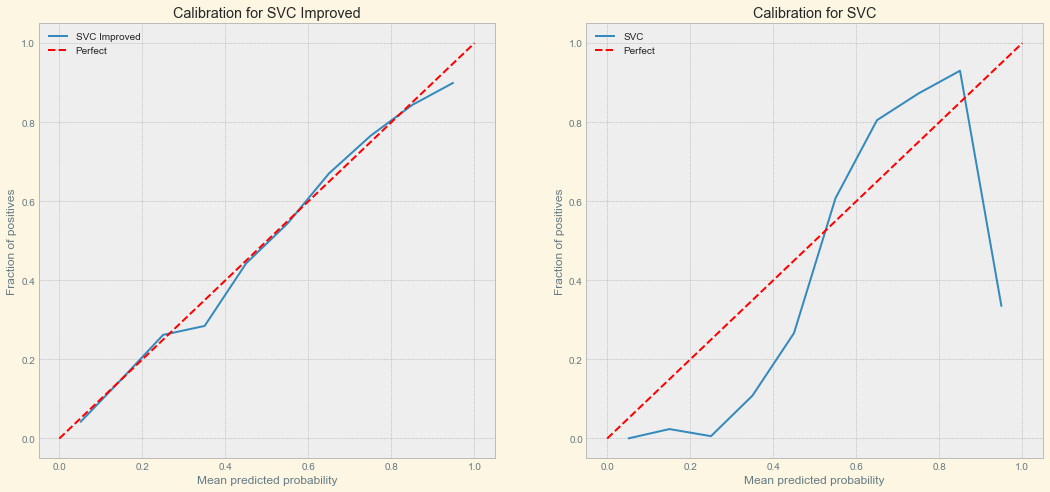

In [1484]:
calibrated_clf = CalibratedClassifierCV(LinearSVC(), cv=ps)
calibrated_clf.fit(X_train, y_train)
sec_preds = calibrated_clf.predict_proba(X_test)[:, 1]

fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (18, 8))
plot_calibration_curve(y_test, sec_preds, 'SVC Improved', ax)
plot_calibration_curve(y_test, preds_svc1, 'SVC', ax)
ax[0].set(xlabel='Mean predicted probability', ylabel='Fraction of positives')
ax[1].set(xlabel='Mean predicted probability', ylabel='Fraction of positives')
plt.show()

__Бонусное задание (0.5 балла).__ Реализуйте свою функцию для калибровки вероятностей. Опишите ваш подход и продемонстрируйте результаты. Ключевые слова для вдохновения: `Platt`, `Isotonic`.

In [ ]:
#your code here

# Часть 1. Работа с переменными.

В этой части мы научимся обрабатывать категориальные переменные, так как закодировать их в виде чисел недостаточно (это задаёт некоторый порядок, которого на категориальных переменных может и не быть). Существует два основных способа обработки категориальных значений:
- One-hot-кодирование
- Счётчики (CTR, mean-target кодирование, ...) — каждый категориальный признак заменяется на среднее значение целевой переменной по всем объектам, имеющим одинаковое значение в этом признаке.

Начнём с one-hot-кодирования. Допустим наш категориальный признак $f_j(x)$ принимает значения из множества $C=\{c_1, \dots, c_m\}$. Заменим его на $m$ бинарных признаков $b_1(x), \dots, b_m(x)$, каждый из которых является индикатором одного из возможных категориальных значений:
$$
b_i(x) = [f_j(x) = c_i]
$$

__Подготовка данных.__

Загрузим данные [UCI Bank Marketing Dataset](https://archive.ics.uci.edu/ml/datasets/bank+marketing). Этот датасет содержит информацию о банковском телефонном маркетинге, объектом в нем является телефонный звонок потенциальному клиенту с предложением некоторой услуги (утверждается, что это краткосрочный депозит), целевой переменной - ответ клиента (согласился ли он открыть депозит?). В качестве признакового описания используются характеристики клиента (образование, брак и т.д.), данные о звонке и различные экономические индикаторы - более подробная информация представлена в файле `bank-additional-names.txt`.

In [1485]:
df = pd.read_csv('bank-additional/bank-additional-full.csv', sep=';')

In [1424]:
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


__Задание 3 (0.5 балла).__ Разделите выборку на обучающую и тестовую в соотношении 3:1. Зафиксируйте `random_state=777`, также используйте `stratify`. Один из столбцов в данных не несет информации для решения задачи — какой? Отбросьте его. 



In [1486]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

df.y = df.y == 'yes'
df.drop(columns=['duration'], inplace = True)
X_train, X_test, y_train, y_test = train_test_split(
    df.iloc[:, 0:-1], df.y, test_size=0.25, random_state=777, stratify=df.y)

Закодируйте категориальные признаки с помощью `OrdinalEncoder`. Посчитайте качество (в этом задании будем работать c `AUC-PR`) при применении логистической регрессии. Замерьте время, потребовавшееся на обучение модели (с учетом кодирования признаков).

__Вопрос__: почему в данном задании мы выбрали метрикой именно `AUC-PR`, а не, к примеру, `AUC-ROC`?

__Ваш ответ__: баланс классов крайне низкий, поэтому страдающий от несбалансированности таргета ROC проигрывает более устойчивому PR.

In [1409]:
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.pipeline import make_pipeline
import time

clf = ColumnTransformer([
    ('orig', OrdinalEncoder(), X_train.select_dtypes([object]).columns),
    ('scaling', StandardScaler(), X_train.select_dtypes(exclude=[object]).columns)
])

pipeline = Pipeline([
    ('orig_and_scaling', clf),
    ('Regression', LogisticRegression(max_iter=100000))
])
st = time.time()
model = pipeline.fit(X_train, y_train)
lr_predict = model.decision_function(X_test)
print('Время работы алгоритма:', time.time() - st)
print('Значение AP:', average_precision_score(y_test, lr_predict))

0.534796953201294
0.4422857876222158


__Задание 4 (0.5 балла).__ Закодируйте все категориальные признаки с помощью one-hot-кодирования. Обучите логистическую регрессию и посмотрите, как изменилось качество модели (с тем, что было до кодирования). Измерьте время, потребовавшееся на кодирование категориальных признаков и обучение модели.



In [1410]:
clf = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), X_train.select_dtypes([object]).columns),
    ('scaling', StandardScaler(), X_train.select_dtypes(exclude=[object]).columns)
])

pipeline = Pipeline([
    ('ohe_and_scale', clf),
    ('Regression', LogisticRegression(max_iter=100000))
])
st = time.time()
model = pipeline.fit(X_train, y_train)
lr_predict = model.decision_function(X_test)
print('Время работы алгоритма:', time.time() - st)
print('Значение AP:', average_precision_score(y_test, lr_predict))

0.8561491966247559
0.4495095155082412


Как можно было заменить, one-hot-кодирование может сильно увеличивать количество признаков, что сказывается на памяти, особенно, если некоторый признак имеет большое количество значений. Эту проблему решает другой способ кодирования категориальных признаков — mean-target encoding (для простоты будем называть это счётчиками). Основная идея в том, что нам важны не сами категории, а значения целевой переменной, которые имеют объекты этой категории. Каждый категориальный признак мы заменим средним значением целевой переменной по всем объектам этой же категории:
$$
g_j(x, X) = \frac{\sum_{i=1}^{l} [f_j(x) = f_j(x_i)][y_i = +1]}{\sum_{i=1}^{l} [f_j(x) = f_j(x_i)]}
$$

__Задание 5 (1 балл).__ Закодируйте категориальные переменные с помощью счётчиков (ровно так, как описано выше без каких-либо хитростей). Обучите логистическую регрессию и посмотрите на качество модели на тестовом множестве. Сравните время обучения с предыдущими экспериментами (с учетом кодирования признаков). Заметили ли вы что-то интересное?


__Бонус (1 балл)__: Здесь и далее реализуйте вычисление счетчиков с помощью трансформера (наследуйтесь от классов `BaseEstimator, TransformerMixin` из `sklearn.base`). Обратите внимание, что все вычисления должны быть векторизованными, трансформер не должен модифицировать передаваемую ему выборку inplace, а все необходимые статистики нужно считать только по обучающей выборке в методе `fit`. Ваш трансформер должен принимать при инициализации список из категориальных признаков и изменять только их. 


In [1376]:
from sklearn.base import BaseEstimator, TransformerMixin

def magic_transform(df):
    tmp = df.copy()
    train = pd.DataFrame()
    for col in list(tmp.select_dtypes([object]).columns):
        seria = tmp.groupby(col)
        seria = seria.aggregate(np.mean).reset_index()[[col, 'y']].rename({'y': col + '_upd'}, axis=1)
        tmp = pd.merge(tmp, seria, on=col)
        tmp[col] = tmp[col + '_upd']
        tmp.drop([col+'_upd'], inplace=True, axis=1)
        train = pd.concat([train,seria], axis=1)
    return tmp

In [1413]:
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.pipeline import make_pipeline
import time

df_2 = magic_transform(df)
X_train, X_test, y_train, y_test = train_test_split(
    df_2.iloc[:, 0:-1], df_2.y, test_size=0.25, random_state=777, stratify=df_2.y)

clf = ColumnTransformer([
    ('scaling', StandardScaler(), X_train.select_dtypes(exclude=[object]).columns)
])

pipeline = Pipeline([
    ('scale', clf),
    ('Regression', LogisticRegression(max_iter=100000))
])

st = time.time()
model = pipeline.fit(X_train, y_train)
lr_predict = model.decision_function(X_test)
print('Время работы алгоритма:', time.time() - st)
print('Значение AP:', average_precision_score(y_test, lr_pred))

0.16305088996887207
0.43633108635576034


In [1491]:
class MagicTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, lst):
        super().__init__()
        self.cat = lst
        self.train = pd.DataFrame()
    
    def fit(self, X_train, y_train):
        X = X_train.copy()
        y = y_train.copy()
        tmp = pd.concat([X, pd.Series(y)], axis=1)
        for col in self.cat:
            seria = tmp.groupby(col)
            seria = seria.aggregate(np.mean).reset_index()[[col, 'y']].rename({'y': col + '_upd'}, axis=1)
            self.train = pd.concat([self.train,seria], axis=1)
        return self
    
    def transform(self, X_test):
        tmp = X_test.copy()
        for col in self.cat:
            tmp = pd.merge(tmp, self.train[[col, col + '_upd']], on=col)
            tmp[col] = tmp[col + '_upd']
            tmp.drop([col+'_upd'], inplace=True, axis=1)
        return tmp

In [1492]:
'''
pipeline = Pipeline(steps=[
    ('mgf', MagicTransformer(X_train.select_dtypes([object]).columns)),
    ('regression',  LogisticRegression())
])
st = time.time()
model = pipeline.fit(X_train, y_train)
lr_predict = model.decision_function(X_test)
print(time.time() - st)
print(average_precision_score(y_test, lr_predict))
'''
X_train, X_test, y_train, y_test = train_test_split(
    df.iloc[:, 0:-1], df.y, test_size=0.25, random_state=777, stratify=df.y)

st = time.time()
mgf = MagicTransformer(lst = list(X_train.select_dtypes([object]).columns))
mgf.fit(X_train, y_train)
model = LogisticRegression(max_iter=100000)

df_2 = mgf.transform(df)
X_train, X_test, y_train, y_test = train_test_split(
    df_2.iloc[:, 0:-1], df_2.y, test_size=0.25, random_state=777, stratify=df_2.y)
model.fit(X_train, y_train)
lr_pred = model.decision_function(X_test)

print('Время работы алгоритма:', time.time() - st)
print('Значение AP:', average_precision_score(y_test, lr_pred))

Время работы алгоритма: 1.046022891998291
Значение AP: 0.4142690627498235


Отметим, что такие признаки сами по себе являются классификаторами и, обучаясь на них, мы допускаем "утечку" целевой переменной в признаки. Это ведёт к переобучению, поэтому считать такие признаки необходимо таким образом, чтобы при вычислении для конкретного объекта его целевая метка не использовалась. Это можно делать следующими способами:
1. Вычислять значение счётчика по всем объектам расположенным выше в датасете (например, если у нас выборка отсортирована по времени).
2. Вычислять по фолдам, то есть делить выборку на некоторое количество частей и подсчитывать значение признаков по всем фолдам кроме текущего (как делается в кросс-валидации).
3. Внесение некоторого шума в посчитанные признаки. 

__Задание 6.__ Реализуйте корректное вычисление счётчиков самым простым способом — добавление шума к значениям (постарайтесь найти баланс между борьбой с переобучением и сохранением полезности признаков). Снова обучите логистическую регрессию, оцените качество. Сделайте выводы.

__(0.5 балла)__

In [1494]:
class NoiseTransformer(MagicTransformer):
    
    def transform(self, X_test):
        tmp = X_test.copy()
        noise = 0.1
        for col in self.train.select_dtypes(exclude=[object]):
            self.train[col] += np.random.normal(0, 1.3, self.train[col].shape[0])
        for col in self.cat:
            tmp = pd.merge(tmp, self.train[[col, col + '_upd']], on=col)
            tmp[col] = tmp[col + '_upd']
            tmp.drop([col+'_upd'], inplace=True, axis=1)
        return tmp
'''
pipeline = Pipeline(steps=[
    ('nst', NoiseTransformer(X_train.select_dtypes([object]).columns)),
    ('regression',  LogisticRegression())
])
st = time.time()
model = pipeline.fit(X_train, y_train)
lr_predict = model.decision_function(X_test)
print(time.time() - st)
print(average_precision_score(y_test, lr_predict))

'''
X_train, X_test, y_train, y_test = train_test_split(
    df.iloc[:, 0:-1], df.y, test_size=0.25, random_state=777, stratify=df.y)    
st = time.time()   
nst = NoiseTransformer(lst = list(X_train.select_dtypes([object]).columns))
nst.fit(X_train, y_train)

df_2 = nst.transform(df)
X_train, X_test, y_train, y_test = train_test_split(
    df_2.iloc[:, 0:-1], df_2.y, test_size=0.25, random_state=777, stratify=df_2.y)

model = LogisticRegression(max_iter=100000)
model.fit(X_train, y_train)
lr_pred = model.decision_function(X_test)


print('Время работы алгоритма:', time.time() - st)
print('Значение AP:', average_precision_score(y_test, lr_pred))

Время работы алгоритма: 0.8613409996032715
Значение AP: 0.3536844359292154


__(Бонусная часть, 0.5 балла)__ Посчитайте корректные счётчики первым или вторым способов из описанных выше (не забудьте добавить и шум). 



In [1350]:
#your code here

А теперь ответьте на следующий **вопрос**: что будет, если некоторая категория встречается в выборке всего несколько раз? 

Так как мало объектов с данным признаком, итоговый счетчик будет слишком сильно зависим от каждого из них, что в итоге понижает устойчивость к выбросам.

По этой причине производится сглаживание счётчиков. Например, на практике хорошие результаты показывает использование сглаживания средним по всей выборке:
$$
g_j(x, X) = \frac{\sum_{i=1}^{\ell} [f_j(x) = f_j(x_i)][y_i = +1] + C \times global\_mean}{\sum_{i=1}^{\ell} [f_j(x) = f_j(x_i)] + C}
$$
где $global\_mean$ — доля объектов положительного класса в выборке, $C$ — параметр, определяющий степень сглаживания (например, можно использовать 10 или подобрать для каждого признака свой). Основная идея в том, что мы "разбавляем" среднее значение по некоторой категории глобальным средним значением. И тем меньше, чем большее количество объектов этой категории встречается в выборке. 

Однако для сглаживания вместо среднего значения целевой переменной можно использовать любое другое значение от 0 до 1 (этот параметр иногда называют $prior$). Можно сделать несколько признаков с разными значениями параметра. На практике в задачах бинарной классификации полезными бывают даже отрицательные значения!


__Задание 7 (1 балл).__ Добавьте сглаживание, описанное выше и повторите эксперименты.

In [1399]:
class LikeJaggerTransform(MagicTransformer):        
    def fit(self, X_train, y_train, C):
        X = X_train.copy()
        y = y_train.copy()
        tmp = pd.concat([X, pd.Series(y)], axis=1)
        for col in self.cat:
            seria = tmp.groupby(col)
            seria = ((seria['y'].aggregate(np.sum) + C * tmp.y.mean()) / 
            (seria['y'].aggregate(np.size) + C)).reset_index()[[col, 'y']].rename({'y': col + '_upd'}, axis=1)
            self.train = pd.concat([self.train,seria], axis=1)
        return self

In [1495]:
pipeline = Pipeline(steps=[
    ('ljt', LikeJaggerTransform(X_train.select_dtypes([object]).columns)),
    ('regression',  LogisticRegression())
])
'''
st = time.time()
model = pipeline.fit(X_train, y_train, ljt__C=1)
lr_predict = model.decision_function(X_test)
print(time.time() - st)
print(average_precision_score(y_test, lr_predict))
'''
X_train, X_test, y_train, y_test = train_test_split(
    df.iloc[:, 0:-1], df.y, test_size=0.25, random_state=777, stratify=df.y)    
st = time.time()    
ljt = LikeJaggerTransform(lst = list(X_train.select_dtypes([object]).columns))
ljt.fit(X_train, y_train, C = 1)

df_2 = ljt.transform(df)
X_train, X_test, y_train, y_test = train_test_split(
    df_2.iloc[:, 0:-1], df_2.y, test_size=0.25, random_state=777, stratify=df_2.y)

model = LogisticRegression(max_iter=100000)
model.fit(X_train, y_train)
lr_pred = model.decision_function(X_test)

print('Время работы алгоритма:', time.time() - st)
print('Значение AP:', average_precision_score(y_test, lr_pred))

Время работы алгоритма: 0.8172721862792969
Значение AP: 0.4123727135240477


__Задание 8 (0.5 балла).__ В данных имеется признак "возраст клиента". Сейчас мы интерпретируем его как числовой, что в общем случае для линейной модели может быть неверной гипотезой. Тем не менее, у этого признака есть довольно много уникальных значений (сколько - 78), поэтому применять к нему one-hot кодирование может оказаться излишним. Попробуйте закодировать возраст с помощью счетчиков. Стало ли лучше?



In [1496]:
'''
pipeline = Pipeline(steps=[
    ('ljt', LikeJaggerTransform(list(X_train.select_dtypes([object]).columns) + ['age'])),
    ('regression',  LogisticRegression())
])
st = time.time()
model = pipeline.fit(X_train, y_train, ljt__C=1)
lr_predict = model.decision_function(X_test)
print(time.time() - st)
print(average_precision_score(y_test, lr_predict))
'''
X_train, X_test, y_train, y_test = train_test_split(
    df.iloc[:, 0:-1], df.y, test_size=0.25, random_state=777, stratify=df.y)    

st=time.time()    
ljt = LikeJaggerTransform(lst = list(X_train.select_dtypes([object]).columns) + ['age'])
ljt.fit(X_train, y_train, C = -0.1)

df_2 = ljt.transform(df)
X_train, X_test, y_train, y_test = train_test_split(
    df_2.iloc[:, 0:-1], df_2.y, test_size=0.25, random_state=777, stratify=df_2.y)

model = LogisticRegression()
model.fit(X_train, y_train)
lr_pred = model.decision_function(X_test)


print('Время работы алгоритма:', time.time() - st)
print('Значение AP:', average_precision_score(y_test, lr_pred))

Время работы алгоритма: 0.9952771663665771
Значение AP: 0.4104406410093563


Можно пойти и в обратную сторону. У нас есть признаки "месяц и день недели" для звонка. Попробуйте интерпретировать их как числовые (месяц от 0 до 12, дни недели от 0 до 4). Стало ли лучше в этот раз?

In [1497]:
'''
clf = ColumnTransformer([
    ('oe', OrdinalEncoder(), ['day_of_week', 'month']),
], remainder='passthrough')

lst1 = ['job','marital', 'education', 'default', 'housing', 'loan', 'contact', 'poutcome']

pipeline = Pipeline(steps=[
    ('ljt', LikeJaggerTransform(lst1)),
    ('ohe_and_scale', clf),
    ('regression',  LogisticRegression())
])
st = time.time()
model = pipeline.fit(X_train, y_train, ljt__C=1)
lr_predict = model.decision_function(X_test)
print(time.time() - st)
print(average_precision_score(y_test, lr_predict))

'''
X_train, X_test, y_train, y_test = train_test_split(
    df.iloc[:, 0:-1], df.y, test_size=0.25, random_state=777, stratify=df.y)    
st=time.time()    
lst1 = list(X_train.select_dtypes(include=[object]).columns)
lst1.remove('day_of_week')
lst1.remove('month')
ljt = LikeJaggerTransform(lst1)
ljt.fit(X_train, y_train, C = 1000)

df_2 = ljt.transform(df)
X_train, X_test, y_train, y_test = train_test_split(
    df_2.iloc[:, 0:-1], df_2.y, test_size=0.25, random_state=777, stratify=df_2.y)

clf = ColumnTransformer([
    ('oe', OrdinalEncoder(), ['day_of_week', 'month']),
    ('scaling', StandardScaler(), X_train.select_dtypes(exclude=[object]).columns)
], remainder='passthrough')
pipeline = Pipeline([
    ('ohe_and_scale', clf),
    ('Regression', LogisticRegression(max_iter=100000))
])

model = pipeline.fit(X_train, y_train)
lr_predict = model.decision_function(X_test)
print('Время работы алгоритма:', time.time() - st)
print('Значение AP:', average_precision_score(y_test, lr_pred))

Время работы алгоритма: 0.9012758731842041
Значение AP: 0.4106104400783411


__Замечание.__ Усложнение методов вычисления счётчиков не делают результаты модели гарантированно лучше. Особенно с учётом того, что логистическая регрессия не такая сложная модель, чтобы переобучаться. Поэтому вы необязательно должны были получать на каждом шаге всё лучшие и лучшие результаты (но необходимые результаты у вас должны были получиться).

Как вы должны были заметить, счётчики являются хорошей альтернативой one-hot-кодированию. **Напишите, какие плюсы и минусы использования счётчиков по сравнению с one-hot-кодированием вы заметили.**

__Ответ:__ С одной стороны, поражает улучшение в быстроте получения ответов. Контролируя вопрос шума и переобучения, а также сглаженности, мы можем избежать значительного увеличения объема данных. Однако риски переобучения и поражения от шумов при отсутсвии должного контроля намного выше.

# Часть 2. Отбор признаков

Важной частью процесса построения модели является отбор признаков. На практике многие признаки оказывают малое влияние на модель (при этом их расчёт занимает время) или даже негативно сказываются на качестве модели. Попробуем несколько подходов отбора признаков, оценим, как они влияют на качество модели и сколько времени занимают.

Обратимся к тем же данным про банковский телефонный маркетинг.

In [1733]:
df = pd.read_csv('bank-additional/bank-additional-full.csv', sep=';')

X = df.drop(columns=['duration', 'y'])
y = (df.y == 'yes')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=777, stratify=y)

Как вы помните, в данных много категориальных признаков (сейчас давайте интерпретировать возраст как числовой). Давайте закодируем их с помощью one-hot кодирования. Исходные колонки с категориальными признаками можно удалить. Сколько признаков мы получили?

In [1691]:
clf = ColumnTransformer([
    ('ohe', OneHotEncoder(), X_train.select_dtypes([object]).columns),
], remainder='passthrough')
pipeline = Pipeline([
    ('ohe', clf)
])
tmp = X_train.copy()
pipeline.fit_transform(tmp).shape[1]

62

В качестве основной модели будем использовать логистическую регрессию, а целевой метрики — `AUC-PR`. Обучите модель и посчитайте качество на тестовой выборке. Давайте запомним полученное значение.

In [1692]:
clf = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), X_train.select_dtypes([object]).columns),
    ('scaling', StandardScaler(), X_train.select_dtypes(exclude=[object]).columns)
])

pipeline = Pipeline([
    ('ohe_and_scale', clf),
    ('Regression', LogisticRegression(max_iter=100000))
])
st = time.time()
model = pipeline.fit(X_train, y_train)
lr_predict = model.decision_function(X_test)
print('Время работы алгоритма:', time.time() - st)
print('Значение AP:', average_precision_score(y_test, lr_predict))
seva = model['Regression'].coef_[0]

Время работы алгоритма: 1.0539731979370117
Значение AP: 0.4477466523796595


### Встроенные методы

Допустим, мы хотим оставить только 40 лучших признаков. Попробуем сделать это несколькими способами.

Начнём с отборам признаков с помощью линейной модели. Как известно, веса линейной модели означают вклад каждого признака в предсказание модели, а значит, модуль этого вклада можно интерпретировать как важность признаков. Такой метод отбора называются встроенным или embedded method, так как он заложен в особенности модели.

__Задание 8 (0.5 балла).__ Оставьте 40 признаков с наибольшим модулем соответствующего параметра линейной модели. Обучите модели заново и оцените её качество. Замерьте скорость такого отбора признаков.

Изменилось ли качество? Как?



Качество незначительно изменилось в худшую сторону (на тысячные).

In [1661]:
class LeftConst(BaseEstimator, TransformerMixin):
    def __init__(self, coefs, constant):
        super().__init__()
        self.top = np.argpartition(coefs, -constant)[-constant:] # со stack
    
    def fit(self, x, y=None):
        return self
    
    def transform(self, X, y=None):
        tmp = X.copy()
        return tmp[:, self.top]
        
pipeline = Pipeline([
    ('ohe_and_scale', clf),
    ('top', LeftConst(seva, 40)),
    ('Regression', LogisticRegression(max_iter=100000))
])
st = time.time()
model = pipeline.fit(X_train, y_train)
lr_predict = model.decision_function(X_test)
print('Время работы алгоритма:', time.time() - st)
print('Значение AP:', average_precision_score(y_test, lr_predict))

Время работы алгоритма: 0.8682858943939209
Значение AP: 0.44555797785902845


А теперь давайте подумаем, что мы не учли. Мы предположили, что признаки вносят вклад равномерно, но не учли их масштаба. Если мы умножим один из признаков в 100 раз, то без учёта регуляризации его вес уменьшится в эти же 100 раз. А мы на основе этого отбираем признаки! Давайте сначала отмасштабируем признаки одним из способов, а только потом будем удалять признаки. 

Кстати, в таком случае надо пересчитать качество на всех признаках (сделайте это ниже). Если вы сделали нормирование признаков в самом начале, то попробуйте отобрать признаки на неотмасштабированных данных.

Что получилось?

На немасштабируемых качество значительно упало.

In [1662]:
clf = ColumnTransformer([
    ('ohe', OneHotEncoder(), X_train.select_dtypes([object]).columns),
], remainder='passthrough')

pipeline = Pipeline([
    ('ohe', clf),
    ('Regression', LogisticRegression(max_iter=100000))
])

st = time.time()
model = pipeline.fit(X_train, y_train)
lr_predict = model.decision_function(X_test)
print('Время работы алгоритма:', time.time() - st)
print('Значение AP:', average_precision_score(y_test, lr_predict))
print()
seva = model['Regression'].coef_[0]

pipeline = Pipeline([
    ('ohe', clf),
    ('top', LeftConst(seva, 40)),
    ('Regression', LogisticRegression())
])
st = time.time()
model = pipeline.fit(X_train, y_train)
lr_predict = model.decision_function(X_test)
print('Время работы алгоритма:', time.time() - st)
print('Значение AP:', average_precision_score(y_test, lr_predict))

Время работы алгоритма: 1.022467851638794
Значение AP: 0.430085395431181

Время работы алгоритма: 0.9636430740356445
Значение AP: 0.3931333868148987


Вопрос на засыпку: one-hot кодирование возвращает нам единичные признаки-индикаторы. Попробуйте также отскалировать их, как и обычные числовые, и снова выбрать 40 главных по вкладу признаков. Изменился ли их список? Изменится ли качество?

Качество упало.

In [1663]:
clf = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), X_train.select_dtypes([object]).columns),
])
ss = StandardScaler(with_mean=False)

pipeline = Pipeline([
    ('ohe', clf),
    ('scaling', ss),
    ('Regression', LogisticRegression(max_iter=100000))
])
st = time.time()
model = pipeline.fit(X_train, y_train)
lr_predict = model.decision_function(X_test)
print('Время работы алгоритма:', time.time() - st)
print('Значение AP:', average_precision_score(y_test, lr_predict))
print()
seva = model['Regression'].coef_[0]

        
pipeline = Pipeline([
    ('ohe_and_scale', clf),
    ('top', LeftConst(seva, 40)),
    ('Regression', LogisticRegression())
])
st = time.time()
model = pipeline.fit(X_train, y_train)
lr_predict = model.decision_function(X_test)
print('Время работы алгоритма:', time.time() - st)
print('Значение AP:', average_precision_score(y_test, lr_predict))

Время работы алгоритма: 0.3571758270263672
Значение AP: 0.4090656824540044

Время работы алгоритма: 0.5412888526916504
Значение AP: 0.40894111091317836


### Методы фильтрации


Давайте отбирать признаки умнее, а именно через подсчёт некоторой функции для каждого признака. На основании значений этой функции будем оставлять наиболее важные признаки. Методы этого семейства называют фильтрующими или  filter methods. 

В качестве такой функции будем считать t-статистику:

$$t(j) = \frac{|\mu_+ - \mu_-|}{\sqrt{\frac{n_+ \sigma^2_+ + n_- \sigma^2_-}{n_+ + n_-}}},$$

где $\mu$, $\sigma$, $n$ соответственно среднее, стандартное отклонение и количество объектов каждого из классов.

__Задание 9 (0.5 балла).__ Оставьте 40 признаков с наибольшим значением $t$ и замерьте качество. Не забудьте замерить скорость отбора признаков в этом случае.



In [1664]:
def filtration(X_sc, y):
    X = X_sc.copy()
    numerator = abs(X[y == 1].mean() - X[y == 0].mean())
    plus_size, minus_size = X[y == 1].size, X[y == 0].size
    denominator = plus_size * X[y==1].std() ** 2 + minus_size * X[y==0].std() ** 2
    denominator /= plus_size + minus_size
    return (numerator / np.sqrt(denominator))

In [1665]:
clf = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), X_train.select_dtypes([object]).columns),
    ('scaling', StandardScaler(), X_train.select_dtypes(exclude=[object]).columns)
])

X_train_sc = clf.fit_transform(X_train)
coefs = []
for i in range(X_train_sc.shape[1]): coefs.append(filtration(X_train_sc[:, i], y_train))

In [1666]:
pipeline = Pipeline([
    ('ohe', clf),
    ('scaling', ss),
    ('top', LeftConst(coefs, 40)),
    ('Regression', LogisticRegression(max_iter=100000))
])
st = time.time()
model = pipeline.fit(X_train, y_train)
lr_predict = model.decision_function(X_test)
print('Время работы алгоритма:', time.time() - st)
print('Значение AP:', average_precision_score(y_test, lr_predict))

Время работы алгоритма: 0.8535430431365967
Значение AP: 0.45166656696923246


### Методы-обёртки

__Задание 10 (1 балл).__ 

Третий из рассматриваемых нами методов работает следующим образом: мы исключаем по очереди один из признаков и смотрим, как это влияет на качество. Удаляем признаки таким жадным способом, пока не окажется выполненым некоторое условие (количество признаков или ухудшение качества).

Заметим, что нельзя оценивать качество по тестовой выборке, иначе мы можем переобучиться, как, например, при настройке гиперпараметров. Разделите обучающую выборку на 2 части, на одной из них обучайте модель без одного из признаков,  на второй части оценивайте качество. Исходную тестовую выборку стоит использовать только для финальной оценки качества.

Снова оставьте только 40 признаков и оцените качество на тестовой выборке. Сколько времени занял такой отбор признаков?

In [1734]:
from sklearn.feature_selection import SequentialFeatureSelector
st = time.time()
test_fold = [-1] * round(len(X_train) * 0.5) + [0] *  round(len(X_train) * 0.5)
random.shuffle(test_fold)
ps = PredefinedSplit(test_fold)

estimator = LogisticRegression()
selector_b = SequentialFeatureSelector(estimator, cv=ps, direction='backward',
                                     scoring = make_scorer(average_precision_score), n_features_to_select=40)
selector_b.fit(X_train_sc, y_train)
print('Время:', time.time() - st)

Время: 43714.299567222595


In [1668]:
st = time.time()
selector_f = SequentialFeatureSelector(estimator, cv=ps, direction='forward',
                                     scoring = make_scorer(average_precision_score), n_features_to_select=40)
selector_f.fit(X_train_sc, y_train)
print('Время:', time.time() - st)

Время: 286.18719506263733


In [1684]:
backw_param = [i for i, x in enumerate(selector_b.support_) if x]
forw_param = [i for i, x in enumerate(selector_f.support_) if x]
print('Индексы выбранных параметров обратным проходом:', backw_param)
print('Индексы выбранных параметров прямым проходом:', forw_param)

Индексы выбранных параметров обратным проходом: [1, 2, 4, 5, 6, 7, 8, 9, 12, 16, 18, 21, 22, 23, 25, 27, 29, 30, 34, 36, 37, 38, 40, 41, 42, 43, 44, 46, 48, 49, 50, 51, 53, 54, 55, 56, 58, 59, 60, 61]
Индексы выбранных параметров прямым проходом: [0, 2, 3, 4, 6, 7, 10, 11, 12, 13, 14, 15, 16, 17, 19, 20, 21, 23, 25, 26, 27, 28, 29, 30, 31, 32, 35, 36, 37, 38, 39, 40, 41, 43, 44, 45, 53, 55, 60, 61]


In [1731]:
clf = ColumnTransformer([
    ('ohe', OneHotEncoder(), X_train.select_dtypes([object]).columns),
], remainder='passthrough')

X = pd.DataFrame(clf.fit_transform(X))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=777, stratify=y)

In [ ]:
X_train1 = X_train[X_train.columns[backw_param]]
X_test1 = X_test[X_test.columns[backw_param]]

st = time.time()
model = LogisticRegression.fit(X_train1, y_train)
lr_pred = model.decision_function(X_test1)
print('Время работы алгоритма:', time.time() - st)
print('Значение AP:', average_precision_score(y_test, lr_pred))

In [ ]:
X_train2 = selector_f.transform(X_train)
X_test2 = selector_f.transform(X_test)

st = time.time()
model = LogisticRegression.fit(X_train2, y_train) # здесь какая-то странная ошибка
lr_pred = model.decision_function(X_test2)
print('Время работы алгоритма:', time.time() - st)
print('Значение AP:', average_precision_score(y_test, lr_pred))

Стоит отметить, что с помощью такого метода можно пойти и в обратную сторону. Попробуйте _добавлять_ по одному самому полезному признаку в выборку до тех пор, пока не наберется 40 штук. Найдется ли порог, при котором добавление следующих признаков будет только ухудшать качество модели? 
Да, найдется. RFECV выбирает оптимальное число.

In [1728]:
estimator = LogisticRegression(max_iter=100000)
selector = RFECV(estimator, cv=ps, scoring=make_scorer(average_precision_score))
selector = selector.fit(X_train, y_train)
selector.n_features_

48

Давайте подведём итоги по отбору признаков. Назовите преимущества и недостатки каждого из методов. Какой метод привёл к наилучшему качеству?

**Ответ:** 
Первый, оберкти запускался один раз и был весьма долгим из-за большого массива данных, однако дал не самый лучший результат. - запускать один раз обучение (долго если много данных). Т-статистика дала отличные результаты по времени в среднем, но значения сильно зависели от подбора гиперпараметра. Последний оказался самым тяжелым, но он эффективно помогает избавиться от шумов.


# Часть 3. Оценка экономического эффекта модели

В данной части мы займемся тем, что от вас скорее всего потребуется на реальной работе (помимо перекладки `json`, разумеется). А именно: мы соберем несколько специализированных метрик качества, попытаемся настроить модель на максимизацию _прибыли_ и оценим, сколько вообще получится заработать на этом. Разумеется, здесь будет сделано множество упрощающих жизнь допущений, но обо всем по порядку. 

__Задание 11 (1 балл).__ Допустим, работники вашего колл-центра получают за один звонок клиенту 1 доллар. При согласии клиента на предлагаемые условия он принесет в банк 10 долларов.

Если вы всё прослушали на экономике, то напомним, что выручка — это сколько денег нам принесли клиенты, а прибыль — выручка за вычетом расходов на зарплату и прочее.

Загрузите данные о телемаркетинге из предыдущего блока заданий. В этой части не нужно делить выборку - мы будем использовать кросс-валидацию. Используйте 5 фолдов, сделайте `shuffle=True, random_state=500`. По кросс-валидации у вас получится 5 вариантов обучающей и тестовой выборки. Обучите логистическую регрессию на каждой обучающей выборке (воспользуйтесь one-hot для категориальных признаков, гиперпараметры оставьте со значениями по умолчанию) и сделайте предсказания для соответствующих тестовых выборок. Допустим, всем положительным прогнозам ваши сотрудники решили позвонить. Посчитайте на всех тестовых выборках выручку и усредните. Сколько денег вы в среднем заработаете? Также вычислите стандартное отклонение.

Сколько из заработанных денег придётся отдать операторам вашего колл-центра?

In [1720]:
from sklearn.model_selection import KFold, cross_validate

df = pd.read_csv('bank-additional/bank-additional-full.csv', sep=';')

X = df.drop(columns=['duration', 'y'])
y = (df.y == 'yes')

clf = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), X.select_dtypes([object]).columns),
], remainder='passthrough')

pipeline = Pipeline([
    ('ohe', clf),
    ('Regression', LogisticRegression(max_iter=100000))
])

profit = []
costs = []
kf = KFold(n_splits=5, shuffle=True, random_state=500)
for train_index, test_index in kf.split(X):
    X_train, X_test = X.loc[train_index, :], X.loc[test_index, :]
    y_train, y_test = y[train_index], y[test_index]
    model = pipeline.fit(X_train, y_train)
    lr_pred = model.predict(X_test)
    step = np.sum(lr_pred & y_test)
    profit.append(step * 10)
    costs.append(np.sum(lr_pred))
print('Выручка:', np.mean(profit))
print('Отклонение выручки:', np.std(profit))
print('Траты:', np.mean(costs))
print('Прибыль:', np.mean(np.array(profit)-np.array(costs)))
print('Отклонение прибыли:', np.std(np.array(profit) - np.array(costs)))

Выручка: 2106.0
Отклонение выручки: 60.860496218811754
Траты: 313.6
Прибыль: 1792.4
Отклонение прибыли: 62.86048043087167


Внесем некоторую долю случайности. Пусть теперь согласный на условия клиент будет приносить не 10 долларов, а случайную величину, равномерно распределенную в интервале $[0;20)$. Проделайте все те же самые действия. Для имитации реальной ситуации **НЕ** фиксируйте `random_seed` при подсчете выручки с клиента. Что получилось?

In [1624]:
profit = []
costs = []
for train_index, test_index in kf.split(X):
    X_train, X_test = X.loc[train_index, :], X.loc[test_index, :]
    y_train, y_test = y[train_index], y[test_index]
    model = pipeline.fit(X_train, y_train)
    lr_pred = model.predict(X_test)
    step = np.sum(lr_pred & y_test)
    profit.append(np.random.randint(0,20, size = (lr_pred & y_test).sum()).sum())
    costs.append(np.sum(lr_pred))
print('Выручка:', np.mean(profit))
print('Отклонение выручки:', np.std(profit))
print('Траты:', np.mean(costs))
print('Прибыль:', np.mean(np.array(profit)-np.array(costs)))
print('Отклонение прибыли:', np.std(np.array(profit) - np.array(costs)))

Выручка: 2040.6
Отклонение выручки: 76.62793224405837
Траты: 313.6
Прибыль: 1727.0
Отклонение прибыли: 73.61249893869926


Настройте по кросс-валидации коэффициент регуляризации модели для максимизации прибыли (считайте как случайную величину выше). Удалось ли получить какой-то выигрыш? При каком коэффициенте регуляризациии прибыль максимальна? Постройте график зависимости ожидаемой прибыли от коэффициента, также укажите стандартные отклонения (вам поможет `plt.errorbar`).

Выигрыша в прибыли нет, лишь в скорости и эффективности вычислений.

In [1625]:
def TP(y_test, lr_pred):
    return np.sum(np.random.randint(0,20, size = y_test.shape[0]) * (y_test & lr_pred))
    

X_train_scaled = clf.fit_transform(X_train)
alphas_C = np.logspace(-3, 2, num=20)
searcher_C = GridSearchCV(LogisticRegression(max_iter=100000), [{"C": alphas_C}], 
                              scoring=make_scorer(TP), cv=kf)
searcher_C.fit(X_train_scaled, y_train)
best_alpha_C = searcher_C.best_params_["C"]
print("Best alpha = %.4f" % best_alpha_C)

Best alpha = 0.2336


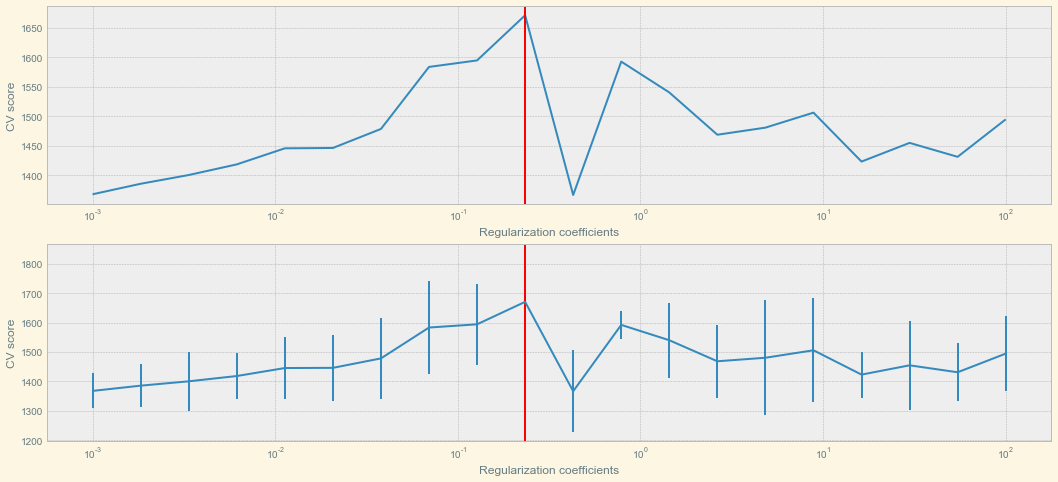

In [1640]:
fig, ax = plt.subplots(figsize=(18, 8), nrows=2, ncols=1)
ax[1].errorbar(x=alphas_C, y=searcher_C.cv_results_["mean_test_score"], yerr=searcher_C.cv_results_['std_test_score'])
ax[1].set_xscale("log")
ax[1].set_xlabel("Regularization coefficients")
ax[1].set_ylabel("CV score")
ax[1].axvline(x=best_alpha_C, c='red')

ax[0].plot(alphas_C, searcher_C.cv_results_["mean_test_score"])
ax[0].set_xscale("log")
ax[0].set_xlabel("Regularization coefficients")
ax[0].set_ylabel("CV score")
ax[0].axvline(x=best_alpha_C, c='red')

plt.show()

Попробуйте запустить перебор несколько раз. Находится ли каждый раз один и тот же "лучший" коэффициент? Присутствует ли какая-то закономерность? Какие вы можете сделать из этого выводы?

In [1642]:
for i in range(3):
    alphas_C = np.logspace(-3, 2, num=20)
    searcher_C = GridSearchCV(LogisticRegression(max_iter=100000), [{"C": alphas_C}], 
                              scoring=make_scorer(TP), cv=kf)
    searcher_C.fit(X_train_scaled, y_train)
    best_alpha_C = searcher_C.best_params_["C"]
    print("Best alpha = %.4f" % best_alpha_C)

Best alpha = 0.2336
Best alpha = 0.2336
Best alpha = 0.2336


Коэффициент повторяется. Закономерность в стабильности. Вне зависимости от количеств переборов, искомый максимум графика будет оставаться тем же.

__Задание 12 (1 балл).__ Выше мы уже описали примерную экономическую модель вашей задачи. Как вы считаете, что для вашего бизнеса важнее — хороший precision или recall модели? Почему?

__Ответ:__ Нам важней recall, тк штраф за неправильный ответ (-1) намного меньше выручки от удачно найденного клиента (+10). Конечно, нельзя не учитывать дисбаланс классов. Однако если соглашающихся клиентов больше 10%, полнота будет более важной метрикой.



Вспомним, что на самом деле логистическая регрессия предсказывает нам вероятности положительного класса для объекта. Возможно, путем настройки порога бинаризации этих вероятностей мы сможем получить какой-то выигрыш? Проверьте ваши рассуждения выше с помощью настройки порога бинаризации на кросс-валидации для максимизации прибыли. Воспользуйтесь сеткой от 0 до 1 с шагом 0.01. Напомним, что снижение порога дает нам более высокий recall и более низкий precision, и наоборот.

In [1653]:
pred_proba_df = pd.DataFrame(searcher_C.predict_proba(X_train_sc))
threshold_list = np.arange(0, 1, 0.01)
costs = []
profit = []
best_r = 0
best_t = 0
yaxis = []
for i in threshold_list:
    print(i)
    for train_index, test_index in kf.split(X):
        X_train, X_test = X.loc[train_index, :], X.loc[test_index, :]
        y_train, y_test = y[train_index], y[test_index]
        model = pipeline.fit(X_train, y_train)
        lr_pred = i < model.predict_proba(X_test)[:, 1]
        step = np.sum(lr_pred & y_test)
        profit.append(np.random.randint(0,20, size = (lr_pred & y_test).sum()).sum())
        costs.append(np.sum(lr_pred))
    tp = np.mean(np.array(profit)-np.array(costs))
    yaxis.append(tp)
    if best_r < tp: 
        best_r = tp
        best_t = i

0.0
0.01
0.02
0.03
0.04
0.05
0.06
0.07
0.08
0.09
0.1
0.11
0.12
0.13
0.14
0.15
0.16
0.17
0.18
0.19
0.2
0.21
0.22
0.23
0.24
0.25
0.26
0.27
0.28
0.29
0.3
0.31
0.32
0.33
0.34
0.35000000000000003
0.36
0.37
0.38
0.39
0.4
0.41000000000000003
0.42
0.43
0.44
0.45
0.46
0.47000000000000003
0.48
0.49
0.5
0.51
0.52
0.53
0.54
0.55
0.56
0.5700000000000001
0.58
0.59
0.6
0.61
0.62
0.63
0.64
0.65
0.66
0.67
0.68
0.6900000000000001
0.7000000000000001
0.71
0.72
0.73
0.74
0.75
0.76
0.77
0.78
0.79
0.8
0.81
0.8200000000000001
0.8300000000000001
0.84
0.85
0.86
0.87
0.88
0.89
0.9
0.91
0.92
0.93
0.9400000000000001
0.9500000000000001
0.96
0.97
0.98
0.99


Постройте график зависимости прибыли от порога бинаризации, также отметьте на нем стандартные отклонения. Выделите наилучший порог. 


__Вопрос:__ Замечаете ли вы какую-то закономерность? Для правильного ответа на этот вопрос попробуйте запустить несколько раз и задумайтесь, почему порог получается в какой-то конкретной области?

In [1656]:
print(best_t)

0.27


Видно, что область лучшего порога близка к получившемуся коэф. регуляризации в предфдущем номере.

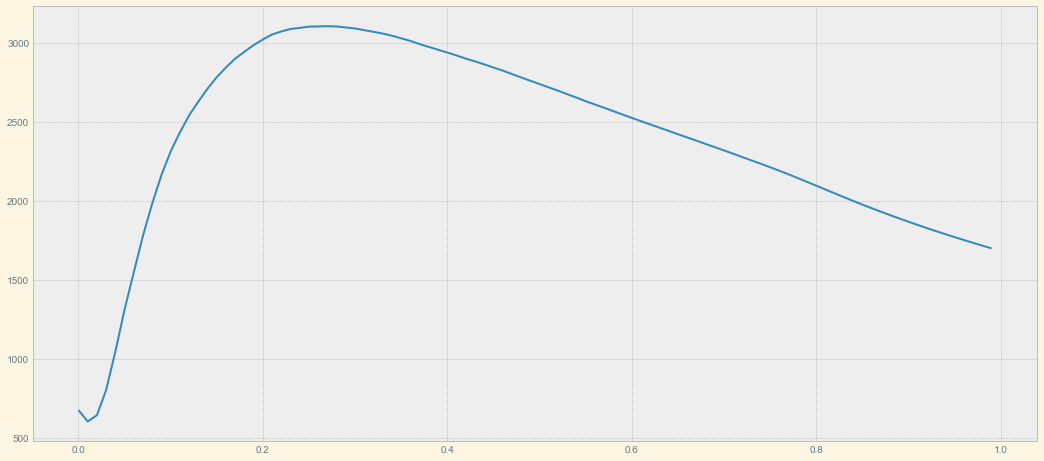

In [1680]:
plt.subplots(figsize=(18, 8))
plt.plot(np.arange(0, 1, 0.01), yaxis)
plt.show()

Каковы значения precision и recall на выбранном пороге? Оцените по кросс-валидации. Также вычислите стандартное отклонение.

In [1721]:
one = 0
two = 0
for train_index, test_index in kf.split(X):
        X_train, X_test = X.loc[train_index, :], X.loc[test_index, :]
        y_train, y_test = y[train_index], y[test_index]
        model = pipeline.fit(X_train, y_train)
        lr_pred = best_t < model.predict_proba(X_test)[:, 1]
        step = np.sum(lr_pred & y_test)
        one += step / (lr_pred.sum() * 5)
        two += step / (y_test.sum() * 5)

In [1722]:
print('Precision:', one)
print('Recall:', two)

Precision: 0.4765599410460953
Recall: 0.45109925639506937


Как вы, вероятно, уже поняли, ваша модель склоняется к более высокому recall. Попробуйте оценить качество модели с помощью `PR-AUC` в зоне recall $\geq$ 0.5. Сделайте это следующим образом - выберите только те пороги, на которых достигается необходимый recall, затем интерпретируйте отсеченный в единичном квадрате прямоугольник как новый единичный квадрат и посчитайте площадь под отсеченной кривой. 

In [ ]:
#your code here

__Бонус (0.01 балла):__ что вы кушали в день сдачи данного ДЗ на завтрак?

__Ответ:__ трудно сказать что именно кушал в день сдачи, если твой день длится больше 20 часов. выпил очень вкусный кофе с булочкой)

__Социализационный бонус (0.1 балл).__
Введены новые ограничения, занятия теперь дистанционные. Но это не значит, что не надо общаться с друзьями! Созвонитесь в зуме (или любым другим способом) хотя бы с двумя студентами курса МО-1 этого года, приложите скриншот созвона с включенными камерами и напишите очень кратко, на какие темы были беседы.

__Ответ:__ ![](./unknown.png)